In [298]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from optimizers.simulations.order import simulate_lqe_model
from optimizers.cross_validators import vbt_cv_sliding_constructor
from research.statistics import rolling_zscore_nb, kalmanfilter, kelly_criterion
from research.pipes.sql import SQLPipe

load_dotenv()

USER = os.getenv('PSQL_USERNAME')
PASS = os.getenv('PSQL_USERNAME')
DATABASE = 'crypto'
SCHEMA = 'hourly'
FREQ = '60T'

pipe = SQLPipe(SCHEMA, DATABASE, USER, PASS, FREQ)

In [299]:
assets = ['ALGO-USDT', 'NFT-USDT']
slicer = -13420 # Slice off first few months of trading to reduce early volatility

df = pipe.query_pairs_trading_backtest(assets)
closes = df.xs('close', level=1, axis=1)[slicer:]
opens = df.xs('open', level=1, axis=1)[slicer:]
assert closes.shape[0] > 8640, 'Less than 1 year of backtesting data present'
assert closes.shape == opens.shape, 'Open and close shape does not match'

print(f"Full data length: {closes.shape[0]}")

n = 3
train_opens, test_opens = train_test_split(opens, test_size=0.30, train_size=0.70, shuffle=False)
train_closes, test_closes = train_test_split(closes, test_size=0.30, train_size=0.70, shuffle=False)
close_folds = vbt_cv_sliding_constructor(train_closes, n_splits=n)
open_folds = vbt_cv_sliding_constructor(train_opens, n_splits=n)
seeds = []

for idx in range(0, len(close_folds)):
    if idx == 0:
        seed_set = np.array([])
    else:
        seed_set = pd.concat(close_folds[:idx]).values
    seeds.append(seed_set)
seeds.append(train_closes.values)

print(f"Test data length: {test_opens.shape[0]}")
print(f"Train fold length {close_folds[0].shape[0]}")

Full data length: 13420
Test data length: 4026
Train fold length 3131


In [311]:
# VRA XPR 105 1.3 2.1 0.0 1e-7 9e-5 LOG 30MIN (SHARPE >5)
# ONE VRA LOG 30MIN models work in CV folds, but not OOS; 1HOUR is better
# NFT WIN failed LOG testing @ 30MIN interval
# KDA WAX LOG/CUMLOG failed in 30min interval
# KDA VRA CUMLOG has potential, but sharpe of 1.75 is not high enough
# DOT XPR CUMLOG 755 4.9 -1.5 0.7 6e-5 1.4e-3: 2.2 Sharpe; High ret. Bears further review but had some skew to positive trades
# Further DOT XPR review with seeded modeling procuded extremely poor results in cumlog and log models
# DOT VRA 115 3.0 -1.4 0.0 8e-09 9e-07 CUMLOG <- high OOS sharpe, but shows recent degredation in performance. Consider minimal capital alloc deployment
# BCHSV SOL CUM/LOG/RET failed OOS testing
# XLM VET CUM/LOG/ failed OOS testing
# AAVE XMR + AAVE FIL results are worthless even in-sample

PERIOD = 455
UPPER = 1.5
LOWER = 1.6
EXIT = 0.2
DELTA = 2e-3
VT = 1.9e-0
BURNIN = 200
MODEL = 'log'
HEDGE = 'beta'
SLIPPAGE = 0.0010
SIZE = 0.10
CLOSES = test_closes
OPENS = test_opens
SEED = seeds[n]

In [312]:
pf = simulate_lqe_model(
    CLOSES, OPENS,
    period=PERIOD,
    upper=UPPER,
    lower=LOWER,
    exit=EXIT,
    delta=DELTA,
    vt=VT,
    burnin=BURNIN,
    freq=FREQ,
    hedge=HEDGE,
    transformation=MODEL,
    slippage=SLIPPAGE,
    order_size=SIZE,
    seed=SEED,
)

-0.045412104058670376


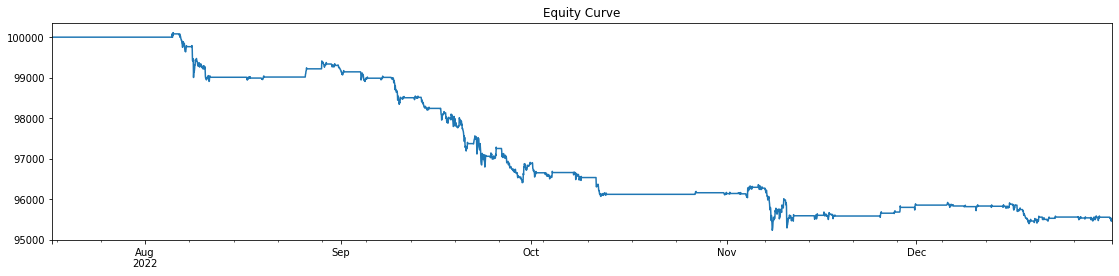

In [313]:
print(pf.total_return())
pf.value().plot(figsize=(19,4))
plt.title('Equity Curve')
plt.show()

In [314]:
pnl = (pf.trades.records_readable.groupby('Entry Timestamp').sum().PnL.resample('D').sum())
val = pf.value().resample('D').asfreq().fillna(pf.value())
res = pd.concat([pnl, val], axis=1, keys=['pnl', 'val'])
res = res.fillna(0)
res['ret'] = res.pnl / res.val
Rf = (1 + 0) ** (1/365) - 1 # Daily risk free rate
Rp = res.ret.mean() # Daily portfolio return
STDp = res.ret.std() # Daily standard deviation of return
sharpe = ((Rp - 0) / STDp) * np.sqrt(365) # Annualized sharpe

In [315]:
trade_df = pf.trades.records_readable.sort_values('Entry Timestamp')
trade_df['entry_size'] = trade_df['Avg Entry Price'] * trade_df['Size']
g = trade_df.groupby('Entry Timestamp')
net_trades = g.sum()
xx = g.first().reset_index()
dur = (xx['Exit Timestamp'] - xx['Entry Timestamp']).dt.total_seconds()/(60*60) # Trade durations in hours
dur.index = xx['Entry Timestamp']
net_trades['duration'] = dur
net_trades['gross_return'] = net_trades['PnL'] / net_trades['entry_size']

print(f"Total trades: {net_trades.shape[0]}")
print(f"Days in sample: {(CLOSES.index.max() - CLOSES.index.min()).days}")
print(f"Net long-short win rate: {net_trades.PnL[net_trades.PnL > 0].shape[0] / net_trades.shape[0] * 100:.2f}%")
print(f"Sharpe ratio: {sharpe:.4f}")
print(f"Profit Ratio: {net_trades.PnL[net_trades.PnL > 0].mean() / np.abs(net_trades.PnL[net_trades.PnL < 0].mean()):.3f}")
print(f"Mean trade profit: {net_trades.PnL.mean():.2f} +/- {net_trades.PnL.std():.2f}")
print(f"Median trade profit: {net_trades.PnL.median():.2f}")
print(f"Duration [hours]: {net_trades.duration.mean():.2f} +/- {net_trades.duration.std():.2f}")

Total trades: 81
Days in sample: 167
Net long-short win rate: 45.68%
Sharpe ratio: -3.7776
Profit Ratio: 0.420
Mean trade profit: -56.06 +/- 189.46
Median trade profit: -4.61
Duration [hours]: 13.12 +/- 12.70


Kurtosis: 5.896849885485125; Skew: -1.707290141952996


<AxesSubplot:ylabel='Frequency'>

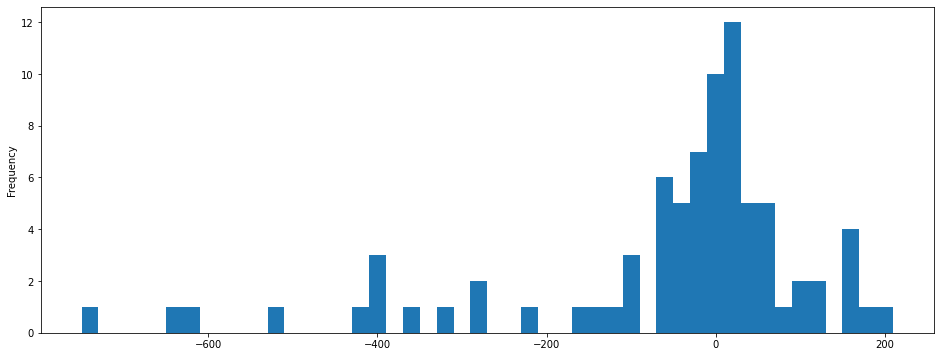

In [316]:
print(f'Kurtosis: {kurtosis(net_trades.PnL, fisher=False)}; Skew: {skew(net_trades.PnL)}')

bins = np.arange(net_trades.PnL.min(), net_trades.PnL.max(), 20)
net_trades.PnL.plot(kind="hist", figsize=(16,6), bins=bins)

<AxesSubplot:>

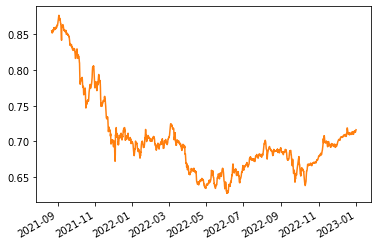

In [317]:
x, y = assets

if MODEL == 'log':
    data = np.log(closes)
elif MODEL == 'logret':
    data = np.log1p(closes.pct_change()).dropna()
elif MODEL == 'cumlog':
    data = np.log1p(closes.pct_change()).cumsum().dropna()

results = kalmanfilter(data, DELTA, VT, export_df=False)
resids = results[2]
res = pd.DataFrame(results[0], index=data.index)
res = res.rename(columns={0: "slope", 1: "intercept"})

trade_df = pf.trades.records_readable.sort_values('Entry Timestamp')
g = trade_df.groupby('Entry Timestamp')
betas = []

for idx, gr in g:
    sign = -1 if gr.Direction.nunique() == 1 else 1
    xv = gr[gr['Column'] == x]
    yv = gr[gr['Column'] == y]
    xval = xv['Size'] * xv['Avg Entry Price']
    yval = yv['Size'] * yv['Avg Entry Price']
    beta = (xval.values / yval.values) * sign
    betas.append(beta)

ser = pd.Series(np.vstack(betas).flatten(), index=trade_df['Entry Timestamp'].unique(), name='beta')

ser[BURNIN:].plot()
res[1500:].slope.plot() # Slice to end of burnin

Kurtosis: 7.892885765464998; Skew: 0.02931231401819686


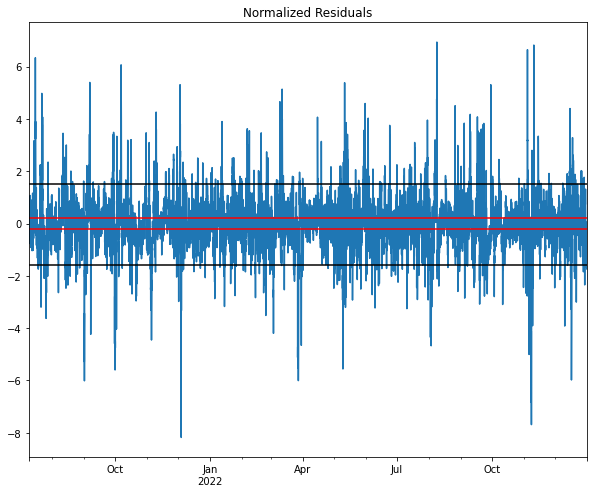

In [318]:
z = rolling_zscore_nb(resids, PERIOD)[PERIOD:]
print(f'Kurtosis: {kurtosis(z, fisher=False)}; Skew: {skew(z)}')

zser = pd.Series(z, index=data.index[PERIOD:], name='z-score')
zser.plot(figsize=(10,8))

plt.axhline(UPPER, color='black')
plt.axhline(-LOWER, color='black')
plt.axhline(EXIT, color='red')
plt.axhline(-EXIT, color='red')
plt.title('Normalized Residuals')
plt.show()

Kurtosis: 7.892885765464998; Skew: 0.02931231401819686


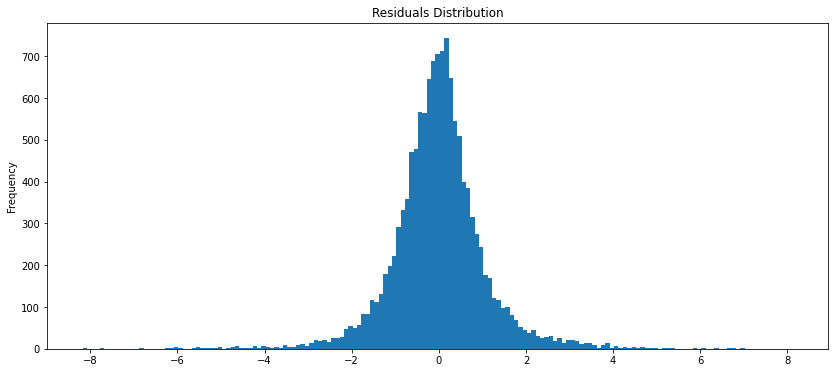

In [319]:
print(f'Kurtosis: {kurtosis(z, fisher=False)}; Skew: {skew(z)}')
z_max = zser.abs().max()
bins = np.arange(-z_max,z_max,0.1)
zser.plot(kind='hist', figsize=(14,6), bins=bins, title='Residuals Distribution')
plt.show()

In [320]:
gross_ret = net_trades.gross_return
p = gross_ret[gross_ret > 0].mean()
q = gross_ret[gross_ret < 0].mean()
p_odds = gross_ret[gross_ret > 0].shape[0] / gross_ret.shape[0]
q_odds = 1 - p_odds

In [321]:
kelly_criterion(p_odds, p, q) * 0.25

-21.376564025530463